In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

### Gradient boost guided example

Having walked through gradient boost by hand, now let's try it with SKlearn.  We'll still use the European Social Survey Data, but now with a categorical outcome: Whether or not someone lives with a partner.

In [2]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Make the categorical variable 'country' into dummies.
df = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)

# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
print (X.head())


# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

   year  tvtot  ppltrst  pplfair  pplhlp  happy  sclmeet  sclact  gndr  agea  \
0     6    3.0      3.0     10.0     5.0    8.0      5.0     4.0   2.0  60.0   
1     6    6.0      5.0      7.0     5.0    9.0      3.0     2.0   2.0  59.0   
2     6    1.0      8.0      8.0     8.0    7.0      6.0     3.0   1.0  24.0   
3     6    4.0      6.0      6.0     7.0   10.0      6.0     2.0   2.0  64.0   
4     6    5.0      6.0      7.0     5.0    8.0      7.0     2.0   2.0  55.0   

   CH  CZ  DE  ES  NO  SE  
0   1   0   0   0   0   0  
1   1   0   0   0   0   0  
2   1   0   0   0   0   0  
3   1   0   0   0   0   0  
4   1   0   0   0   0   0  


Since we're now working with a binary outcome, we've switched to a classifier.  Now our loss function can't be the residuals.  Our options are "deviance", or "exponential".  Deviance is used for logistic regression, and we'll try that here.

In [3]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
print (table_train.loc['All','All'])
print (table_train)
print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))


7332
col_0     0.0   1.0   All
partner                  
0.0      4167   341  4508
1.0      1291  1533  2824
All      5458  1874  7332
Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17607746863066012

Test set accuracy:
Percent Type I errors: 0.06257668711656442
Percent Type II errors: 0.18527607361963191


Unlike decision trees, gradient boost solutions are not terribly easy to interpret on the surface.  But they aren't quite a black box.  We can get a measure of how important various features are by counting how many times a feature is used over the course of many decision trees.

<class 'numpy.ndarray'>


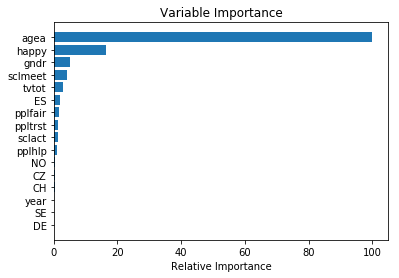

[2.71896141e-01 3.02840860e+00 1.41566220e+00 1.70066601e+00
 1.23084214e+00 1.65032826e+01 4.20038229e+00 1.38299644e+00
 5.11383330e+00 1.00000000e+02 3.53383670e-01 5.32887821e-01
 7.26677173e-02 2.03128912e+00 5.55396992e-01 2.19074782e-01]


In [4]:
feature_importance = clf.feature_importances_
print (type(feature_importance))
# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()
print (feature_importance)

It appears that age and happiness are the most important features in predicting whether or not someone lives with a partner.

### DRILL: Improve this gradient boost model

While this model is already doing alright, we've seen from the Type I and Type II error rates that there is definitely room for improvement.  Your task is to see how low you can get the error rates to go in the test set, based on your model in the training set.  Strategies you might use include:

* Creating new features
* Applying more overfitting-prevention strategies like subsampling
* More iterations
* Trying a different loss function
* Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

Have fun!


Applying more overfitting-prevention strategies like subsampling
More iterations
Trying a different loss function
Changing the structure of the weak learner: Allowing more leaves in the tree, or other modifications

In [5]:
# Predicting the model and testing initially to see the error rate first without applying these measures

y_pred=clf.predict(X_test)

from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test, y_pred)
print (conf_mat)
print ('The sensitivity i.e true positives is {0:2f}% '.format((conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]))*100))
print ('The specificity i.e true negatives is {0:2f}% '.format((conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))*100))
print ('The Type I error i.e. false negatives is {0:2f}% '.format((conf_mat[1,0]/(conf_mat[1,0]+conf_mat[0,0]))*100))
print ('The Type II error i.e. false positives is {0:2f}% '.format((conf_mat[0,1]/(conf_mat[0,1]+conf_mat[1,1]))*100))

[[454  51]
 [151 159]]
The sensitivity i.e true positives is 51.290323% 
The specificity i.e true negatives is 89.900990% 
The Type I error i.e. false negatives is 24.958678% 
The Type II error i.e. false positives is 24.285714% 


### Creating new features

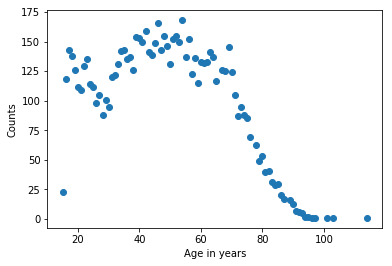

In [6]:
plt.scatter(x=df.agea.value_counts().index , y=df.agea.value_counts())
plt.xlabel('Age in years')
plt.ylabel('Counts')
plt.show()

In [7]:
# added senior citizens variable based on age
df['age_seniors']=np.where(df['agea'] > 60, 1, 0)

In [8]:
#added happy binary feature
df['happy_binary']=np.where(df['happy']> 6, 1, 0)

In [9]:
#added Gender binary feature as 1 and 0 which is male and female instead of 2 and 1
df['gender_binary']=df['gndr']-1

In [10]:
#added Social meet binary feature as 1 and 0 which is meeting socially or not
df['sclmeet_binary']=np.where(df['sclmeet']> 5, 1, 0)

In [11]:
# Changed the partner i.e the outcome variable into binary outcome variable in the dataframe
df['partner']=df['partner']-1

### Applying more overfitting-prevention strategies like subsampling

In [12]:
# Make the categorical variable 'country' into dummies.

X=df.loc[:, ~(df.columns).isin(['partner', 'cntry', 'idno'])].sample(frac=0.3, replace=True, random_state=1)
Y=df.partner.sample(frac=0.3, replace=True, random_state=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], Y[:offset]


# And put 10% in the test set.
X_test, y_test = X[offset:], Y[offset:]


In [13]:
# Fitting the model and testing how these two measures help in lowering the errors

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

conf_mat=confusion_matrix(y_test, y_pred)
print (conf_mat)
print ('The sensitivity i.e true positives is {0:2f}% '.format((conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]))*100))
print ('The specificity i.e true negatives is {0:2f}% '.format((conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))*100))
print ('The Type I error i.e. false negatives is {0:2f}% '.format((conf_mat[1,0]/(conf_mat[1,0]+conf_mat[0,0]))*100))
print ('The Type II error i.e. false positives is {0:2f}% '.format((conf_mat[0,1]/(conf_mat[0,1]+conf_mat[1,1]))*100))

[[138  17]
 [ 44  46]]
The sensitivity i.e true positives is 51.111111% 
The specificity i.e true negatives is 89.032258% 
The Type I error i.e. false negatives is 24.175824% 
The Type II error i.e. false positives is 26.984127% 


Even after adding new features and doing sub-sampling there is no reduction in errors in prediction

### More iterations and : Allowing more leaves in the tree,

In [14]:
params = {'n_estimators': 5000,
          'max_depth': 3,
          'loss': 'deviance'}
# Make the categorical variable 'country' into dummies.

X=df.loc[:, ~(df.columns).isin(['partner', 'cntry', 'idno'])].sample(frac=0.3, replace=True, random_state=1)
Y=df.partner.sample(frac=0.3, replace=True, random_state=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], Y[:offset]


# And put 10% in the test set.
X_test, y_test = X[offset:], Y[offset:]

# Fitting the model and testing how these two measures help in lowering the errors

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

conf_mat=confusion_matrix(y_test, y_pred)
print (conf_mat)
print ('The sensitivity i.e true positives is {0:2f}% '.format((conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]))*100))
print ('The specificity i.e true negatives is {0:2f}% '.format((conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))*100))
print ('The Type I error i.e. false negatives is {0:2f}% '.format((conf_mat[1,0]/(conf_mat[1,0]+conf_mat[0,0]))*100))
print ('The Type II error i.e. false positives is {0:2f}% '.format((conf_mat[0,1]/(conf_mat[0,1]+conf_mat[1,1]))*100))


[[131  24]
 [ 30  60]]
The sensitivity i.e true positives is 66.666667% 
The specificity i.e true negatives is 84.516129% 
The Type I error i.e. false negatives is 18.633540% 
The Type II error i.e. false positives is 28.571429% 


Beyond 5000 iterations and 3 leaves there is no further improvement in error. But increasing the iterations and number of leaves reduced the type I error a little but increase type II error too.

### Trying a different loss function
### Changing the structure of the weak learner:

In [15]:
params = {'n_estimators': 5000,
          'max_depth': 3,
          'loss': 'exponential'}
# Make the categorical variable 'country' into dummies.

X=df.loc[:, ~(df.columns).isin(['partner', 'cntry', 'idno'])].sample(frac=0.3, replace=True, random_state=1)
Y=df.partner.sample(frac=0.3, replace=True, random_state=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], Y[:offset]


# And put 10% in the test set.
X_test, y_test = X[offset:], Y[offset:]

# Fitting the model and testing how these two measures help in lowering the errors

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

conf_mat=confusion_matrix(y_test, y_pred)
print (conf_mat)
print ('The sensitivity i.e true positives is {0:2f}% '.format((conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]))*100))
print ('The specificity i.e true negatives is {0:2f}% '.format((conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))*100))
print ('The Type I error i.e. false negatives is {0:2f}% '.format((conf_mat[1,0]/(conf_mat[1,0]+conf_mat[0,0]))*100))
print ('The Type II error i.e. false positives is {0:2f}% '.format((conf_mat[0,1]/(conf_mat[0,1]+conf_mat[1,1]))*100))


[[133  22]
 [ 32  58]]
The sensitivity i.e true positives is 64.444444% 
The specificity i.e true negatives is 85.806452% 
The Type I error i.e. false negatives is 19.393939% 
The Type II error i.e. false positives is 27.500000% 


Trying a different loss function such as 'exponential' did not help either.

### Balancing the class imbalance in outcome variable


In [22]:
df.partner.value_counts()

0.0    5013
1.0    3134
Name: partner, dtype: int64

we observe here that the partner outcome variable has class imbalance problem. So need to do over sampling or under sampling to avoid overfitting to one class. Here I did equal sampling of both the classes.

In [78]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

# Make the categorical variable 'country' into dummies.
df = pd.concat([df, pd.get_dummies(df['cntry'])], axis=1)

# Changed the partner i.e the outcome variable into binary outcome variable in the dataframe
df['partner']=df['partner']-1
df.partner.value_counts()

0.0    5013
1.0    3134
Name: partner, dtype: int64

In [79]:
# Make the categorical variable 'country' into dummies.
X0=df[df['partner']==0].sample(n=3000, replace=False, random_state=1)
X1=df[df['partner']==1].sample(n=3000, replace=False, random_state=1)

print (X0.partner.value_counts())
print (X1.partner.value_counts())
X=pd.concat([X0,X1])
X.partner.value_counts()
X.sort_index(inplace=True)

0.0    3000
Name: partner, dtype: int64
1.0    3000
Name: partner, dtype: int64


In [80]:
Y=X.partner.sample(frac=0.3, replace=True, random_state=1)
X=X.loc[:, ~(X.columns).isin(['partner', 'cntry', 'idno'])].sample(frac=0.3, replace=True, random_state=1)


# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], Y[:offset]


# And put 10% in the test set.
X_test, y_test = X[offset:], Y[offset:]

# Fitting the model and testing how these two measures help in lowering the errors

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

y_pred=clf.predict(X_test)

conf_mat=confusion_matrix(y_test, y_pred)
print (conf_mat)
print ('The sensitivity i.e true positives is {0:2f}% '.format((conf_mat[1,1]/(conf_mat[1,1]+conf_mat[1,0]))*100))
print ('The specificity i.e true negatives is {0:2f}% '.format((conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1]))*100))
print ('The Type I error i.e. false negatives is {0:2f}% '.format((conf_mat[1,0]/(conf_mat[1,0]+conf_mat[0,0]))*100))
print ('The Type II error i.e. false positives is {0:2f}% '.format((conf_mat[0,1]/(conf_mat[0,1]+conf_mat[1,1]))*100))

[[73 21]
 [21 65]]
The sensitivity i.e true positives is 75.581395% 
The specificity i.e true negatives is 77.659574% 
The Type I error i.e. false negatives is 22.340426% 
The Type II error i.e. false positives is 24.418605% 


Did not reduce the error. Made no difference in the error after doing class imbalance.